# TTS Alignment

Problem with FastSpeech2 or similar models, it required data alignments to align X (commonly melspectrogram) with Y (commonly characters).

Malaya-Speech got 2 TTS models that able to return alignment, Tacotron2 and GlowTTS.

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline
import matplotlib.pyplot as plt
import IPython.display as ipd

In [19]:
# https://www.sinarharian.com.my/article/115216/BERITA/Politik/Syed-Saddiq-pertahan-Dr-Mahathir
string1 = 'Ahli Parlimen Muar Syed Saddiq Syed Abdul Rahman menempelak pihak yang menuduh bekas Perdana Menteri'

## Load Tacotron2 model

Read more about Tacotron2 model at https://malaya-speech.readthedocs.io/en/latest/tts-tacotron2-model.html

In [6]:
osman = malaya_speech.tts.tacotron2(model = 'osman')

## Load GlowTTS model

Read more about Tacotron2 model at https://malaya-speech.readthedocs.io/en/latest/tts-glowtts-model.html

In [7]:
osman_glowtts = malaya_speech.tts.glowtts(model = 'osman')

## Predict alignment

In [20]:
r_osman = osman.predict(string1)

In [21]:
r_osman.keys()

dict_keys(['string', 'ids', 'decoder-output', 'mel-output', 'universal-output', 'alignment'])

In [45]:
r_osman['string']

'Ahli Parlimen Muar Syed Saddiq Syed Abdul Rahman menempelak pihak yang menuduh bekas Perdana Menteri .'

In [22]:
r_osman_glowtts = osman_glowtts.predict(string1)

In [23]:
r_osman_glowtts.keys()

dict_keys(['string', 'ids', 'mel-output', 'alignment', 'universal-output'])

In [46]:
r_osman_glowtts['string']

'Ahli Parlimen Muar Syed Saddiq Syed Abdul Rahman menempelak pihak yang menuduh bekas Perdana Menteri .'

## Plot Tacotron2 alignment

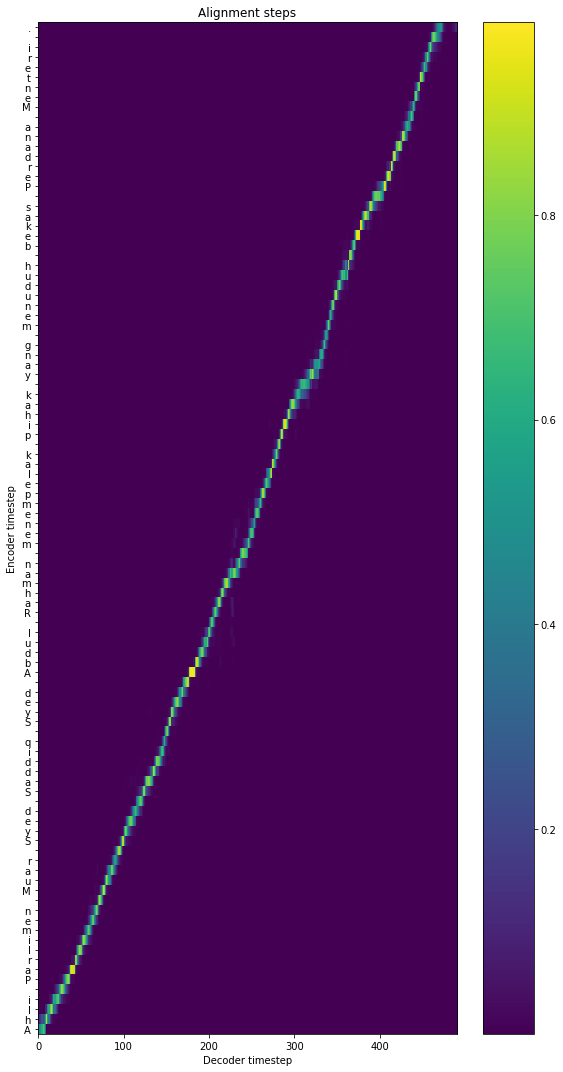

In [32]:
fig = plt.figure(figsize=(8, 15))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    r_osman['alignment'][1:-9],
    aspect='auto',
    origin='lower',
    interpolation='none')
ax.set_yticks(range(len(r_osman['string'])))
labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(r_osman['string'])
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

Why `r_osman['alignment'][1:-9]`?

If you look at `r_osman['ids']`,

In [33]:
r_osman['ids']

array([ 1, 14, 47, 51, 48, 13, 29, 40, 57, 51, 48, 52, 44, 53, 13, 26, 60,
       40, 57, 13, 32, 64, 44, 43, 13, 32, 40, 43, 43, 48, 56, 13, 32, 64,
       44, 43, 13, 14, 41, 43, 60, 51, 13, 31, 40, 47, 52, 40, 53, 13, 52,
       44, 53, 44, 52, 55, 44, 51, 40, 50, 13, 55, 48, 47, 40, 50, 13, 64,
       40, 53, 46, 13, 52, 44, 53, 60, 43, 60, 47, 13, 41, 44, 50, 40, 58,
       13, 29, 44, 57, 43, 40, 53, 40, 13, 26, 44, 53, 59, 44, 57, 48, 13,
        9,  2,  0,  0,  0,  0,  0,  0,  0,  0])

`1` (start of string), `2` (end of string) and `0` (padding), make sure not included it.

## Plot GlowTTS alignment

In [34]:
r_osman_glowtts['ids']

array([ 1, 14, 47, 51, 48, 13, 29, 40, 57, 51, 48, 52, 44, 53, 13, 26, 60,
       40, 57, 13, 32, 64, 44, 43, 13, 32, 40, 43, 43, 48, 56, 13, 32, 64,
       44, 43, 13, 14, 41, 43, 60, 51, 13, 31, 40, 47, 52, 40, 53, 13, 52,
       44, 53, 44, 52, 55, 44, 51, 40, 50, 13, 55, 48, 47, 40, 50, 13, 64,
       40, 53, 46, 13, 52, 44, 53, 60, 43, 60, 47, 13, 41, 44, 50, 40, 58,
       13, 29, 44, 57, 43, 40, 53, 40, 13, 26, 44, 53, 59, 44, 57, 48, 13,
        9,  2,  0,  0])

In [37]:
r_osman_glowtts['alignment'].shape

(106, 233)

GlowTTS was trained with reduced factor of 2, means that, so we need to repeat the output by 2 factor.

In [43]:
import numpy as np

tiled = np.repeat(r_osman_glowtts['alignment'], 2, axis = 1)
tiled.shape

(106, 466)

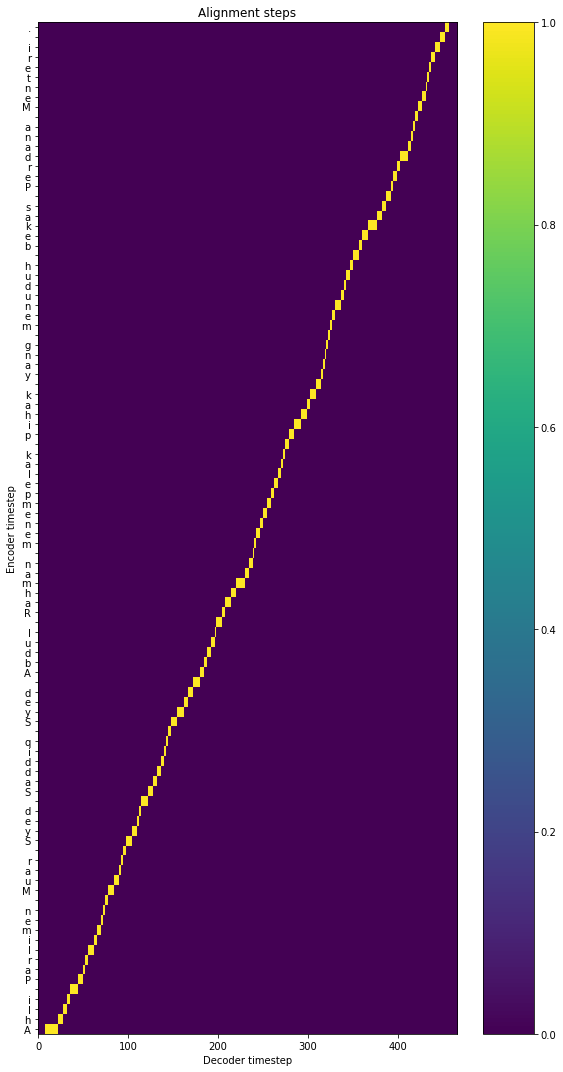

In [44]:
fig = plt.figure(figsize=(8, 15))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    tiled[1:-3],
    aspect='auto',
    origin='lower',
    interpolation='none')
ax.set_yticks(range(len(r_osman['string'])))
labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(r_osman['string'])
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

## Map new feature X with length of text

Let say you have new feature X, eg, f0 with length of X (melspectrogram) and you want to match it with length of text, you can use average by duration from alignment output.

In [51]:
def get_duration_from_alignment(alignment):
    D = np.array([0 for _ in range(np.shape(alignment)[0])])

    for i in range(np.shape(alignment)[1]):
        max_index = list(alignment[:, i]).index(alignment[:, i].max())
        D[max_index] = D[max_index] + 1

    return D

def average_by_duration(x, durs):
    mel_len = durs.sum()
    durs_cum = np.cumsum(np.pad(durs, (1, 0)))

    x_char = np.zeros((durs.shape[0],), dtype=np.float32)
    for idx, start, end in zip(range(mel_len), durs_cum[:-1], durs_cum[1:]):
        values = x[start:end][np.where(x[start:end] != 0.0)[0]]
        x_char[idx] = np.mean(values) if len(values) > 0 else 0.0

    return x_char.astype(np.float32)

In [50]:
get_duration_from_alignment(tiled[1:-3])

array([32,  6,  4,  4,  8,  6,  2,  4,  6,  4,  4,  2,  2,  4,  6,  6,  2,
        2,  4,  6,  6,  2,  2,  8,  6,  4,  4,  4,  2,  2,  4,  6,  8,  4,
        6,  8,  4,  4,  4,  4,  2,  6,  4,  6,  6, 10,  4,  4,  2,  2,  4,
        4,  4,  4,  4,  4,  4,  2,  2,  4,  6,  8,  6,  4,  6,  6,  2,  2,
        2,  2,  2,  2,  4,  6,  4,  2,  4,  4,  6,  4,  6, 10,  6,  4,  6,
        2,  4,  4,  8,  4,  2,  2,  4,  4,  4,  2,  2,  2,  4,  6,  6,  4])